# IMDB Reviews Text Analysis Regression

We used regression to predict the box office revenue for each movie since our features are (or can be made) continuous. Within this file we split our data in train/test and create regression learners to predict the box office revenues.

There are a lot of large files that need to be downloaded to run the actual notebook. Because none of the datasets we used are available online and we manually scraped most of our data, we placed all our data in offline pickle files. Due to the extreme amount of text data required to run this notebook, we ended up with a couple gigabytes of required memory just to run this entire notebook. Since this exceeds the 20MB limit, please contact us if you'd like to see a live demo as we can remote access into the computer that contains all the necessary data.

We set aside three lists for your testing:
    One list with 25 box offices (dependent variable) - 25test_boxoffice_data.pkl
    One list with 25 strings, each representing a concatenation of all the reviews for that movie in the first three weeks
        - 25test_review_data.pkl
    One matrix that's been transformed from a trained count vectorizor - 25X_test_counts.pkl

We included a trained linear regression & random forest model for the review texts. (reviewtext_LR.pkl, reviewtext_RF.pkl)

In [500]:
import requests
from urllib.parse import urljoin
import math
import csv
import time
import sqlite3
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from nltk.corpus import stopwords
from math import log
from sklearn import linear_model
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfTransformer
from collections import defaultdict
import pickle as p


sqlite_file = "C:\\Users\\kevin\\Desktop\\CS 175\\Project\\sqlite\\my_db.sqlite"
review_sqlite_file = "C:\\Users\\kevin\\Desktop\\CS 175\\Project\\sqlite\\review_counts.sqlite"
stopWords = set(stopwords.words('english'))
conn = sqlite3.connect(sqlite_file)
conn1 = sqlite3.connect(review_sqlite_file)
c = conn.cursor()
c1 = conn1.cursor()

We want to extract all of the movie metadata, reviews and review counts into individual arrays that maintain the same order. This is initially so that we can view the spread of our data. We created separate arrays holding normalized budgets and box office. To normalize the data, we take the log 10 of each budget/box office.

In [552]:
all_budgets = []
all_genres = []
all_review_scores = []
normalized_budgets = []
review_counts = []

all_boxoffice = []
normalized_boxoffice = []

with open('movie_metadata.csv', 'r', encoding='utf-8') as moviecsv:
    moviecsv = csv.DictReader(moviecsv)
    count = 0
    for line in moviecsv:
        budget = line["Budget"]
        imdb_id = line["tconst"]
        if budget != "0" and budget != "" and budget != "LOOKINTO":
            review_lengths = c1.execute("SELECT len FROM reviews_score_three WHERE imdb_id ='" + imdb_id + "'").fetchall()
            if not review_lengths:
                review_counts.append(0)
            else:
                review_counts.append(review_lengths[0][0])
            
            all_budgets.append(int(budget))
            normalized_budgets.append(math.log(int(budget), 10))
            box_office = line['BoxOffice'].split(".")[0]
            genre = line['Genre'].lower().strip(" ")
            all_boxoffice.append(int(box_office))
            all_genres.append(genre)
            normalized_boxoffice.append(math.log(int(box_office), 10)) 

all_review_scores = []
review_boxoffice = []
with open('movie_metadata.csv', 'r', encoding='utf-8') as moviecsv:
    moviecsv = csv.DictReader(moviecsv)
    for line in moviecsv:
        imdb_id = line['tconst']
        stmt = "SELECT * FROM reviews_score_three WHERE imdb_id = '" + imdb_id + "'"
        response = c1.execute(stmt).fetchall()
        if len(response) > 0:
            all_review_scores.append(response[0][3])
            box_office = line['BoxOffice'].split(".")[0]
            review_boxoffice.append(math.log(int(box_office), 12))

            
def assign_num_to_genres(genres):
    result = defaultdict(int)
    unique_number = 0
    for genre in genres:
        if result[genre] == 0:
            unique_number += 1
            result[genre] = unique_number
    return result
       

genre_numbers_dict = assign_num_to_genres(all_genres)
# numerical value assigned to each genre
transformed_genres = [genre_numbers_dict[genre] for genre in all_genres]
print("Length of array containing movies with: a budget and reviews: ")
print(len(all_boxoffice))

Length of array containing movies with: a budget and reviews: 
3747


### Distributions of Data

Mean= 5.77341873498799
Median= 6.698970004336019


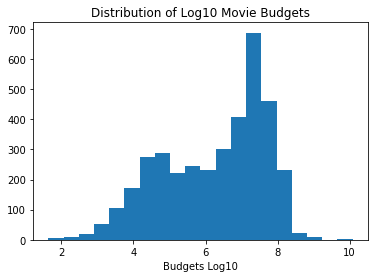

Mean= 29852149.163597547
Median= 2395410


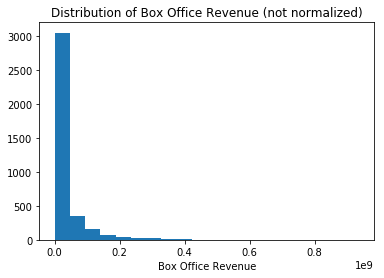

In [502]:
total = 0
count = len(normalized_budgets)
for value in normalized_budgets:
    total += int(value)
mean = total/count
print("Mean= " + str(mean))
median = (sorted(normalized_budgets))[len(normalized_budgets) // 2]
print("Median= " + str(median))


plt.hist(normalized_budgets, 20)
plt.title("Distribution of Log10 Movie Budgets")
plt.xlabel("Budgets Log10")
plt.show()

for value in all_boxoffice:
    total += int(value)
mean = total/count
print("Mean= " + str(mean))
median = (sorted(all_boxoffice))[len(all_boxoffice) // 2]
print("Median= " + str(median))


plt.hist(all_boxoffice, 20)
plt.title("Distribution of Box Office Revenue (not normalized)")
plt.xlabel("Box Office Revenue")
plt.show()

We can see that the data is much more evenly distributed when we take the log 10 of each value. 

## Functions for calculating regression learners

In [503]:
def random_forests(X_train, X_test, Y_train, Y_test, model_name=None):
    clf = RandomForestRegressor(n_estimators = 10, max_depth = 8, random_state = 0).fit(X_train, Y_train)
    if model_name:
#         clf = p.load(open("offline_learners/"+model_name+".pkl", "rb"))
        p.dump(clf, open("offline_learners/"+model_name+".pkl", "wb"))

    
    predicted_RF = clf.predict(X_test)
    mse = np.mean((predicted_RF - Y_test)**2)
    variance = clf.score(X_test, Y_test)
    
    print("Random Forests: ")
    print("MSE= " + str(mse))
    print("variance= " + str(variance))
    
    return clf

In [504]:
 def linear_regression_graph(feature, outcome, title, model_name=None):
    x_train, x_test, y_train, y_test = train_test_split(feature, 
                                                        outcome, test_size=.25)
    x_train_reshape = np.reshape(x_train, (-1, 1))
    x_test_reshape = np.reshape(x_test, (-1, 1))
    
    print("Linear Regression: ")
    regr = linear_model.LinearRegression()
    regr.fit(x_train_reshape, y_train)
    print("coefficients: ", regr.coef_)
    
    if model_name:
#         regr = p.load(open("offline_learners/"+model_name+".pkl", "rb"))
        p.dump(regr, open("offline_learners/"+model_name+".pkl", "wb"))
    
    predicted_LR = regr.predict(x_test_reshape)

    # the mean square error
    mse = np.mean((regr.predict(x_test_reshape)-y_test)**2)
    print("mean squared error: ", mse)

    variance = regr.score(x_test_reshape, y_test) 
    print("variance score: ", variance)

    plt.scatter(x_train, y_train, color="blue")
    plt.plot(np.unique(x_test), 
             np.poly1d(np.polyfit(x_test, y_test, 1))(np.unique(x_test)), color='red')
    if title == "Profit Percentage":
        plt.ylim([0, 500])
    if title == "Review Counts":
        plt.xlim([0, 500])
    plt.xticks(())
    plt.yticks(())
    plt.title("Box Office & "+title)
    plt.ylabel("Box Office")
    plt.xlabel(title)
    plt.show()

# Budget Regression
Here, we calcuate the linear regression & random forest result using budget as the only feature.

Random Forests: 
MSE= 0.699254589508
variance= 0.618371687876
Linear Regression: 
coefficients:  [ 0.75824237]
mean squared error:  0.734378817791
variance score:  0.612807274317


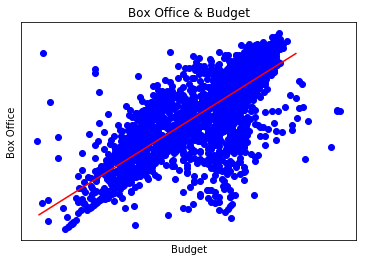

In [507]:
x_train, x_test, y_train, y_test = train_test_split(normalized_budgets, normalized_boxoffice, test_size=.25)
x_train = np.reshape(x_train, (-1, 1))
x_test = np.reshape(x_test, (-1, 1))

random_forests(x_train, x_test, y_train, y_test, "budget_RF")
linear_regression_graph(normalized_budgets, normalized_boxoffice, "Budget")

# IMDB User Review Score Average Regression
Here, we calcuate the linear regression & random forest result using an average of the review scores from the first 3 weeks after movie release as the only feature.

Random Forests: 
MSE= 1.32754436633
variance= 0.221754358962

Linear Regression: 
coefficients:  [-0.10876903]
mean squared error:  1.71597211601
variance score:  0.014052499711


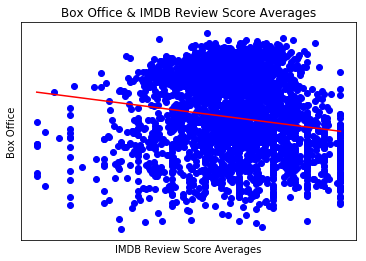

In [508]:
x_train, x_test, y_train, y_test = train_test_split(all_review_scores, review_boxoffice, test_size=.25)
x_train = np.reshape(x_train, (-1, 1))
x_test = np.reshape(x_test, (-1, 1))

random_forests(x_train, x_test, y_train, y_test, "reviewscore_RF")
print()
linear_regression_graph(all_review_scores, review_boxoffice, "IMDB Review Score Averages")

# Genre Regression
We converted the genres to numerical values since there were 67 unique genres and used these values to predict box office revenue.

Random Forests: 
MSE= 1.54944717721
variance= 0.16147308168

Linear Regression: 
coefficients:  [ 0.07202958]
mean squared error:  1.99679858777
variance score:  0.0175194823573


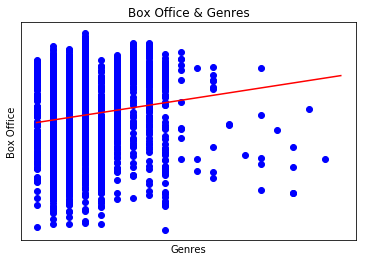

In [509]:
x_train, x_test, y_train, y_test = train_test_split(transformed_genres, 
                                                        normalized_boxoffice, test_size=.25)
x_train = np.reshape(x_train, (-1, 1))
x_test = np.reshape(x_test, (-1, 1))
random_forests(x_train, x_test, y_train, y_test, "genre_RF")
print()
linear_regression_graph(transformed_genres, normalized_boxoffice, "Genres")

# IMDB Review Counts Regression
First, we want to gather all movies that have at least 1 review in the first three weeks

Random Forests: 
MSE= 0.801750420674
variance= 0.574220555311

Linear Regression: 
coefficients:  [ 0.00342608]
mean squared error:  1.53670313396
variance score:  0.210991950888


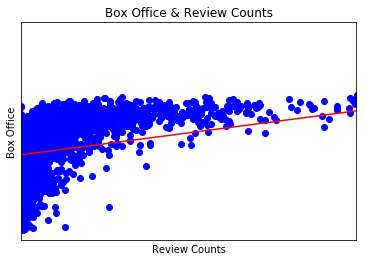

In [510]:

x_train, x_test, y_train, y_test = train_test_split(review_counts, normalized_boxoffice, test_size=.25)

x_train = np.reshape(x_train, (-1,1))
x_test = np.reshape(x_test, (-1,1))
random_forests(x_train, x_test, y_train, y_test, "reviewcount_RF")
print()
linear_regression_graph(review_counts, normalized_boxoffice, "Review Counts")

# IMDB Review Text Analysis
Before we dive into the IMDB review text TFIDF learner, we wanted to analyze the metrics of the review text.
First, we want to see how many movies have at least 1 review in the first 3 weeks of release.

In [511]:
review_rows = c.execute("SELECT imdb_id FROM reviews").fetchall()

review_counts = {}
count = 0
for review in review_rows:
    count += 1
    if count > 0:
        imdb_id = review[0]
        if imdb_id in review_counts:
            review_counts[imdb_id] += 1
        else:
            review_counts[imdb_id] = 1

In [512]:
# Selecting all movies that have at least 1 review in the first three weeks
review_rows = c.execute("SELECT imdb_id FROM reviews").fetchall()
imdb_ids = []
reviews = []
three_weeks_count = []

for review in review_rows:
    count += 1
    if count > 0:
        imdb_id = review[0]
        if imdb_id in review_counts:
            review_counts[imdb_id] += 1
        else:
            review_counts[imdb_id] = 1            

In [513]:
print("Number of movies counted: " + str(len(review_counts)))


review_totals = []
above_40 = 0
above_30 = 0
above_150 = 0
above_20 = []
for imdb_id, review_total in review_counts.items():
    review_totals.append(review_total)
    if review_total > 150:
        above_150 += 1
    if review_total > 40:
        above_40 += 1
    if review_total > 30:
        above_30 += 1
    if review_total > 20:
        above_20.append(imdb_id)

review_totals = np.array(sorted(review_totals))
print("Mean of values: " + str(np.mean(review_totals)))
print("Median of values: " + str(np.median(review_totals)))
print("STD of values: " + str(np.std(review_totals)))
print("Minimum of values: " + str(min(review_totals)))
print("Max of values: " + str(max(review_totals)))

print("Number of movies w/ more than 150 reviews: " + str(above_150))
print("Number of movies w/ more than 40 reviews: " + str(above_40))
print("Number of movies w/ more than 30 reviews: " + str(above_30))

Number of movies counted: 4555
Mean of values: 317.029198683
Median of values: 114.0
STD of values: 586.708052794
Minimum of values: 2
Max of values: 10294
Number of movies w/ more than 150 reviews: 2026
Number of movies w/ more than 40 reviews: 3187
Number of movies w/ more than 30 reviews: 3387


Next, we will move on to gathering our data from our learners. After conducting some tests and figuring out that using data from all movies actually decreased variance, we will stick with the first three weeks.

### First, lets assemble our data for our learners by grabbing reviews from the first three weeks

In [515]:
stmt = "SELECT imdb_id, len, reviews FROM reviews_three"
response = c.execute(stmt).fetchall()

reviews = []
box_offices = []
imdb_ids = []
for row in response:
    if row[1] > 0:
        imdb_ids.append(row[0])
        reviews.append(row[2])
        box = c.execute("SELECT box FROM movies WHERE imdb_id = '" + row[0] + "'").fetchall()[0][0]
        box_offices.append(log(float(box))/log(10))

lab_enc = preprocessing.LabelEncoder()
box_offices = lab_enc.fit_transform(box_offices)



In [516]:
test_review_data = reviews[:25]
test_boxoffice_data = reviews[:25]
p.dump(test_review_data, open("offline_learners/25test_review_data.pkl", "wb"))
p.dump(test_boxoffice_data, open("offline_learners/25test_boxoffice_data.pkl", "wb"))

After checking all the movies, only 3999 out of the about 5000 have reviews within the first three weeks. Next, like put our data in to the correct format for our linear regression.


### Functions for data splitting and learners

In [524]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [519]:
def extract_split_features(train_data, test_data, max_features_val = None, ngrams_val = (1,1)):
    x_train, x_test, y_train, y_test = train_test_split(train_data, test_data, test_size=.25)
    
    count_vect = CountVectorizer(min_df = 3, stop_words = stopWords, max_features = max_features_val)
    X_train_counts = count_vect.fit_transform(x_train)
    X_test_counts = count_vect.transform(x_test)

    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    
    features = count_vect.get_feature_names()
    
    print(top_mean_feats(X_train_tfidf, features, top_n = 25))
#     p.dump(X_test_counts, open("offline_learners/25X_test_counts.pkl", "wb"))

    return (X_train_counts, X_train_tfidf, X_test_counts, X_test_tfidf, y_train, y_test)

In [520]:
# Get top tfidf values in a row and return them with their corresponding feature names
# Source: https://buhrmann.github.io/tfidf-analysis.html

def top_tfidf_feats(row, features, top_n=25):
    
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [527]:
def linear_regression(X_train, X_test, Y_train, Y_test, model_name=None):
    
    from sklearn import linear_model
    clf = linear_model.LinearRegression().fit(X_train, Y_train)
    if model_name:
#         regr = p.load(open("offline_learners/"+model_name+".pkl", "rb"))
        p.dump(clf, open("offline_learners/"+model_name+".pkl", "wb"))
        
    predicted_LR = clf.predict(X_test)
    
    mse = np.mean((predicted_LR - Y_test)**2)
    variance = clf.score(X_test, Y_test)
    
    print("Linear Regression: ")
    print("MSE= " + str(mse))
    print("variance= " + str(variance))
    
    return predicted_LR
        

In [522]:
def support_vector(X_train, X_test, Y_train, Y_test):
    
    from sklearn.svm import SVR
    
    clf = SVR(C=1.0, epsilon=0.2).fit(X_train, Y_train) 
    
    predicted_SVR = clf.predict(X_test)
    mse = np.mean((predicted_SVR - Y_test)**2)
    variance = clf.score(X_test, Y_test)
    
    print("Support Vector Regression: ")
    print("MSE= " + str(mse))
    print("variance= " + str(variance))

Next, we split and count vectorize the features, and print out the top 24 terms with the highest tfidf.

In [523]:
X_train_counts, X_train_tfidf, X_test_counts, X_test_tfidf, Y_train, Y_test = extract_split_features(reviews, box_offices)


        feature     tfidf
0         movie  0.108041
1          film  0.076969
2        horror  0.008280
3           one  0.007916
4          like  0.006192
5        action  0.006160
6         story  0.004970
7           war  0.004889
8   documentary  0.004867
9          khan  0.004174
10    animation  0.004120
11         book  0.003974
12           3d  0.003294
13       family  0.003224
14         good  0.003112
15       akshay  0.003076
16          see  0.002973
17       comedy  0.002823
18         kids  0.002814
19      chinese  0.002786
20          ben  0.002781
21        music  0.002750
22         kate  0.002700
23        funny  0.002698
24         love  0.002694


## Review Text Learners

Let train our learner from just using the count vectorizers.

Next, we'll try with the tfidf vectors

In [528]:
predicted_LR = linear_regression(X_train_counts, X_test_counts, Y_train, Y_test, "reviewtext_LR")
print("")
predicted_RF = random_forests(X_train_counts, X_test_counts, Y_train, Y_test, "reviewtext_RF")


Linear Regression: 
MSE= 160547068.323
variance= -133.402225163

Random Forests: 
MSE= 323934.094383
variance= 0.728818074688


In [529]:
predicted_LR = linear_regression(X_train_tfidf, X_test_tfidf, Y_train, Y_test, "reviewtexttfidf_LR")
print("")
clf_RF = random_forests(X_train_tfidf, X_test_tfidf, Y_train, Y_test, "reviewtexttfidf_RF")



Linear Regression: 
MSE= 549227.586458
variance= 0.540213281303

Random Forests: 
MSE= 342992.073411
variance= 0.712863658234


We noticed in our analysis that review sentiment has very little effect on box office. Lets try to remove polarizing words, to test if that is just causing additional noise. We will add in positive and negative words we found in an online corpus.

In [530]:
polarized = []
fp = open('positive-words.txt')

for i, line in enumerate(fp):
    if i > 34:
        polarized.append(line.strip())


fp = open('negative-words.txt')

for i, line in enumerate(fp):
    if i > 34:
        polarized.append(line.strip())

fp.close()
new_stopwords = text.ENGLISH_STOP_WORDS.union(polarized)


def extract_split_features_no_polarized(train_data, test_data):
    
    x_train, x_test, y_train, y_test = train_test_split(train_data, test_data, test_size=.25)

    count_vect = CountVectorizer(stop_words = new_stopwords, min_df = 3)
    X_train_counts = count_vect.fit_transform(x_train)
    X_test_counts = count_vect.transform(x_test)

    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)

    return (X_train_counts, X_train_tfidf, X_test_counts, X_test_tfidf, y_train, y_test)


In [531]:
X_train_counts, X_train_tfidf, X_test_counts, X_test_tfidf, Y_train, Y_test = extract_split_features_no_polarized(reviews, box_offices)

predicted_LR = linear_regression(X_train_tfidf, X_test_tfidf, Y_train, Y_test)
print("")
clf_RF = random_forests(X_train_tfidf, X_test_tfidf, Y_train, Y_test)


Linear Regression: 
MSE= 555998.210937
variance= 0.522783903654

Random Forests: 
MSE= 326478.702623
variance= 0.719781666666


# Multiple Regression with Budget and Review Counts

We took our two highest performing metadata features, budget and review counts, and combined them into a multi-linear regression.

In [550]:
review_totals = []
nomalized_budgets = []
nomalized_boxoffice = []
reviews = []


with open('movie_metadata.csv', 'r', encoding='utf-8') as moviecsv:
    moviecsv = csv.DictReader(moviecsv)
    count = 0
    for line in moviecsv:
        budget = line["Budget"]
        imdb_id = line['tconst']
        movie_reviews = c.execute("SELECT len, reviews FROM reviews_three WHERE imdb_id ='" + imdb_id + "'").fetchall()
        length = movie_reviews[0][0]
        da_reviews = movie_reviews[0][1]
        if budget != "0" and  length > 0 and budget != "LOOKINTO":
            count += 1
            
            review_totals.append(length)
            reviews.append(da_reviews)
            nomalized_budgets.append(math.log(int(budget), 10))
            
            box_office = line['BoxOffice'].split(".")[0]
            nomalized_boxoffice.append(math.log(int(box_office), 10))
        
        


In [551]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import r2_score


x_reviews_train, x_reviews_test, x_budget_train, x_budget_test, x_total_train, x_total_test, y_bo_train, y_bo_test = train_test_split(reviews, nomalized_budgets, review_totals, nomalized_boxoffice, test_size=.25)


In [538]:

# print(len(x_train_tfidf))
print(len(x_budget_train))


train_data = []
feature_names = ["Budgets", "Review Totals"]
for i in range(len(x_budget_train)):
    train_data.append([x_budget_train[i], x_total_train[i]])
    
test_data = []
for i in range(len(x_budget_test)):
    test_data.append([x_budget_test[i], x_total_test[i]])
df_train = pd.DataFrame(train_data, columns = feature_names)
df_test = pd.DataFrame(test_data, columns = feature_names)
target_train = pd.DataFrame(y_bo_train, columns = ["Box Office"])
target_test = pd.DataFrame(y_bo_test, columns=["Box Office"])


X_train = df_train[feature_names]
X_test = df_test[feature_names]
y_train = target_train["Box Office"]
y_test = target_test["Box Office"]


from sklearn import linear_model
clf = linear_model.LinearRegression().fit(X_train, y_train)
predicted_LR = clf.predict(X_test)

mse = np.mean((predicted_LR - y_test)**2)
variance = r2_score(y_test, predicted_LR)

print("Linear Regression: ")
print("MSE= " + str(mse))
print("variance= " + str(variance))

from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators = 20, max_depth = 7, random_state = 0).fit(X_train, y_train)
predicted_RF = clf.predict(X_test)

# clf = sm.OLS(y_train, X_train).fit()
# predicted_OLS = clf.predict(X_test)

mse = np.mean((predicted_RF - y_test)**2)
variance = r2_score(y_test, predicted_RF)

print("Random Forest: ")
print("MSE= " + str(mse))
print("variance= " + str(variance))


2580
Linear Regression: 
MSE= 0.6140620861524988
variance= 0.637283842861
Random Forest: 
MSE= 0.4691759752592424
variance= 0.722865634265


In [539]:
print(y_test[0:5])
print(predicted_LR[0:5])
print(predicted_RF[0:5])

0    6.081016
1    6.211363
2    7.206519
3    6.889656
4    8.161068
Name: Box Office, dtype: float64
[ 5.45215211  5.3361739   7.28160951  7.28317279  7.22561278]
[ 5.8542498   5.76222556  5.65164135  7.50284053  7.49348833]


# Combining TFIDF with budget, review total features

We created a count vectorizor with stopwords excluded as the only constraint. Transforming the count vectors w/ the tfidf transformer

In [540]:
count_vect = CountVectorizer(stop_words = stopWords, min_df = 3)
X_train_counts = count_vect.fit_transform(x_reviews_train)
X_test_counts = count_vect.transform(x_reviews_test)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


Here, we are appending the normalized (log 10) budget and review totals to our tfidf matrix for both testing and training data

In [541]:
# append features to the training tfidf matrix
for i in range(len(x_budget_train)):
    # add budget and review totals into their own array
    temp = [x_budget_train[i], x_total_train[i]]
    # append this array to the end of each movie's tfidf array so that they become one single array
    np.append(X_train_tfidf[i][0], temp)

    
# append features to the testing tfidf matrix
for i in range(len(x_budget_test)):
    # add budget and review totals into their own array
    temp = [x_budget_test[i], x_total_test[i]]
    # append this array to the end of each movie's tfidf array so that they become one single array
    np.append(X_test_tfidf[i][0], temp)

Using linear regression & random forests on the combined feature matrix to predict box office

In [542]:
predicted_LR = linear_regression(X_train_tfidf, X_test_tfidf, y_bo_train, y_bo_test)
print()
clf_RF = random_forests(X_train_tfidf, X_test_tfidf, y_bo_train, y_bo_test)

Linear Regression: 
MSE= 0.868325666195
variance= 0.487094618134

Random Forests: 
MSE= 0.508438967662
variance= 0.699673644329


In order to reduce noise for our sparse matrix, we only included the top 50 words with highest tfidf scores and well as excluding stop words for our TFIDF vector. We ran the same process for appending our additional features to the TFIDF matrix to calculate the variance w/ linear regression & random forests

In [543]:
count_vect = CountVectorizer(stop_words = stopWords, max_features= 50, min_df = 3)
X_train_counts = count_vect.fit_transform(x_reviews_train)
X_test_counts = count_vect.transform(x_reviews_test)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# append features to the training tfidf matrix
for i in range(len(x_budget_train)):
    # add budget and review totals into their own array
    temp = [x_budget_train[i], x_total_train[i]]
    # append this array to the end of each movie's tfidf array so that they become one single array
    np.append(X_train_tfidf[i][0], temp)

    
# append features to the testing tfidf matrix
for i in range(len(x_budget_test)):
    # add budget and review totals into their own array
    temp = [x_budget_test[i], x_total_test[i]]
    # append this array to the end of each movie's tfidf array so that they become one single array
    np.append(X_test_tfidf[i][0], temp)
    
predicted_LR = linear_regression(X_train_tfidf, X_test_tfidf, y_bo_train, y_bo_test)
print()
clf_RF = random_forests(X_train_tfidf, X_test_tfidf, y_bo_train, y_bo_test)

Linear Regression: 
MSE= 1.33749066074
variance= 0.209966738521

Random Forests: 
MSE= 0.702162196653
variance= 0.585244587801


# K-Fold Cross Validation
Because we ended up with a smaller subset of data, we used a K-Fold cross validation with 10 folds to get the most out of our data.

In [544]:
from sklearn.model_selection import cross_val_score
def cross_validation(X, Y):
    x_reshape = np.reshape(X, (-1, 1))
    linear = linear_model.LinearRegression()
    randomforest = RandomForestRegressor(n_estimators = 15, max_depth = 6, random_state = 0)
    scores = cross_val_score(linear, x_reshape, Y, cv=10)
    print("linear regression")
    print(scores.mean())
    print()
    print("random forest")
    scores = cross_val_score(randomforest, x_reshape, Y, cv=10)
    print(scores.mean())

### Budget 

In [545]:
cross_validation(normalized_budgets, normalized_boxoffice)

linear regression
0.568365478017

random forest
0.588350753079


### Review Score

In [546]:
cross_validation(all_review_scores, review_boxoffice)

linear regression
-0.181693043832

random forest
0.0428008519159


### Genre

In [553]:
cross_validation(transformed_genres, normalized_boxoffice)

linear regression
-0.155996687084

random forest
0.0344178427748


### Review counts in the first 3 weeks

In [554]:
cross_validation(review_counts, normalized_boxoffice)

linear regression
0.0280681050306

random forest
0.522150751656
